In [354]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact

In [355]:
def show_image(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.show()

In [356]:
def show_image_bw(img):
#     rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img, cmap='Greys')
    plt.show()

In [533]:
all_parsed = []

for idx in range(1001, 1606):
    digits = None
    img = cv2.imread('extracted/2/scale_100/IMG_{:04}.JPG'.format(idx))
    
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        cv = conv(gray, False)
        cv = cleanup(cv, False)

        ch = conv(gray, True)
        ch = cleanup(ch, True)

        # show_image_bw(cv)
        # show_image_bw(ch)

        digits = parse_digits(cv, ch)
    except:
        pass
        
    parsed = None
    if digits is not None:
        if all(d is not None for d in digits):
            parsed = 0
            factor = 1
            for i in range(4):
                parsed += factor * digits[i]
                factor /= 10

    all_parsed.append(parsed)

In [534]:
good_count = sum(x is not None for x in all_parsed)
all_count = len(all_parsed)
print(good_count / all_count)

0.8859504132231405


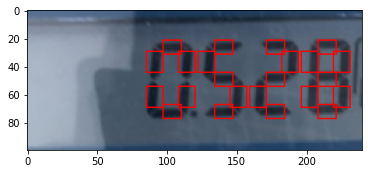

[0, 5, 2, 8]

In [473]:
parse_digits(cv, ch, i)

In [525]:
def parse_digits(cv, ch, colour_img = None):
    x = x_offset(cv)
    y = y_offset(ch)

    if colour_img is not None:
        colour_img = colour_img.copy()
    ch_lines = cv2.cvtColor(ch.astype('float32'), cv2.COLOR_GRAY2BGR)
    cv_lines = cv2.cvtColor(cv.astype('float32'), cv2.COLOR_GRAY2BGR)

    dx = 38

    digits = []

    for digit_idx in range(4):
        lx = x + digit_idx * dx - 4

        s = [
            [(lx     , y +  3), (lx + 12, y + 18)],
            [(lx     , y + 28), (lx + 12, y + 43)],
            [(lx + 23, y +  3), (lx + 35, y + 18)],
            [(lx + 23, y + 28), (lx + 35, y + 43)],
            [(lx + 12, y -  5), (lx + 25, y +  5)],
            [(lx + 12, y + 18), (lx + 25, y + 28)],
            [(lx + 12, y + 41), (lx + 25, y + 51)]
        ]

        seg_on = [False] * 7

        for seg_idx in range(4):
            # cv2.rectangle(cv_lines, s[seg_idx][0], s[seg_idx][1], (0.9,0.6,0.1), 1)

            extracted = cv[s[seg_idx][0][1]:s[seg_idx][1][1], s[seg_idx][0][0]:s[seg_idx][1][0]]
            seg_on[seg_idx] = extracted.sum() > 20

        for seg_idx in range(4,7):
            # cv2.rectangle(ch_lines, s[seg_idx][0], s[seg_idx][1], (0.9,0.6,0.1), 1)

            extracted = ch[s[seg_idx][0][1]:s[seg_idx][1][1], s[seg_idx][0][0]:s[seg_idx][1][0]]
            seg_on[seg_idx] = extracted.sum() > 20

        if colour_img is not None:
            for seg_idx in range(7):
                if seg_on[seg_idx]:
                    cv2.rectangle(colour_img, s[seg_idx][0], s[seg_idx][1], (0,0,255), 1)

        digits.append(decode_digit(seg_on))

    if colour_img is not None:
        show_image(colour_img)
    return digits

In [458]:
def decode_digit(seg_on):
    assert(len(seg_on) == 7)
    
    digits = [
        [1, 1, 1, 1, 1, 0, 1], # 0
        [0, 0, 1, 1, 0, 0, 0], # 1
        [0, 1, 1, 0, 1, 1, 1], # 2
        [0, 0, 1, 1, 1, 1, 1], # 3
        [1, 0, 1, 1, 0, 1, 0], # 4
        [1, 0, 0, 1, 1, 1, 1], # 5
        [1, 1, 0, 1, 1, 1, 1], # 6
        [0, 0, 1, 1, 1, 0, 0], # 7
        [1, 1, 1, 1, 1, 1, 1], # 8
        [1, 0, 1, 1, 1, 1, 1]  # 9
    ]
    
    digit = list(map(lambda b: 1 if b else 0, seg_on))

    try:
        return digits.index(digit)
    except ValueError:
        return None

In [359]:
def x_offset(cv):
    s = cv.sum(axis=0)
    return np.argwhere(s > 15)[0][0]

def y_offset(ch):
    s = ch.sum(axis=1)
    gap = 23
    combined = s[:-gap * 2] + s[gap:-gap] + s[gap * 2:]
    
    margin = 13
    return np.argmax(combined[margin:-margin]) + margin

In [481]:
def conv(img_gray, horizontal):
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    n = 6
    kernel = np.array([[1] + ([-2 / n] * n) + [1]])
    if horizontal:
        kernel = kernel.T

    grad = cv2.filter2D(img_gray, cv2.CV_32F, kernel)
    
    threshold = (grad.max()/2 + 30) / 2
    # print(threshold)
    
    return grad > threshold

# interact(lambda threshold: plt.imshow(grad > threshold), threshold=(20,grad.max()))
# plt.imshow(grad)


In [274]:
def cleanup(img_binary, horizontal):
    kernel_dilate = np.ones((3, 2))
    kernel_open = np.ones((10, 1))
    
    if horizontal:
        kernel_dilate = kernel_dilate.T
        kernel_open = kernel_open.T

    i = cv2.dilate(img_binary * 1.0, kernel_dilate, iterations = 1)
    i = cv2.morphologyEx(i, cv2.MORPH_OPEN, kernel_open)
    
    return i

# show_image_bw(a)

12


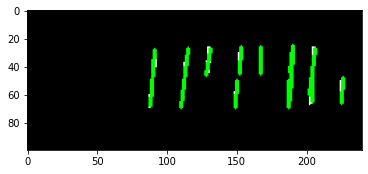

In [225]:
img = np.uint8(a * 255.)

lines = cv2.HoughLinesP(image=img, rho=2, theta=np.pi/50, threshold=35, minLineLength=11, maxLineGap=5)
# print(lines)

rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

nr_lines = 0
if lines is not None:
    for [[x1,y1,x2,y2]] in lines:
        if y1 > 10:
            nr_lines += 1
            cv2.line(rgb,(x1,y1),(x2,y2),(0,255,0),2)

print(nr_lines)
show_image(rgb)